In [1]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from random import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MaxAbsScaler
import warnings
import itertools
from sklearn.metrics import mean_absolute_error as mae
import random
from random import randint
from tqdm import tqdm
from sklearn.metrics import mean_squared_error as mse
import pickle
from sklearn.neural_network import MLPRegressor

# Classes e Funções

In [2]:
def MAPE(y_pred, y_true): 
    mask = y_true != 0
    return (np.fabs(y_true - y_pred)/y_true)[mask].mean()

def check_miss_data(df_in):
    df = df_in.copy()
    df.index = pd.to_datetime(df.Data, dayfirst=True, infer_datetime_format=False)
    idx = pd.date_range(df.index[0], df.index[len(df_exo)-1])
    df = df.reindex(idx, method='pad')
    df.Data = df.index
    df.reset_index(drop=True, inplace=True)
    return df

def ajeitar_ordem(df):
    df_out = pd.DataFrame()
    for mes_ano in df['Month of Din Instante'].unique()[::-1]:
        df_out = df_out.append(df[df['Month of Din Instante'] == mes_ano])
    return df_out

def train_test_split(serie, num_lags, tr_vd_ts_percents = [80, 20], print_shapes = False):
    len_serie = len(serie)
    X = np.zeros((len_serie, num_lags))
    y = np.zeros((len_serie,1))
    for i in np.arange(0, len_serie):
        if i-num_lags>0:
            X[i,:] = serie[i-num_lags:i]
            y[i] = serie[i]
    
    len_train = np.floor(len_serie*tr_vd_ts_percents[0]/100).astype('int')
    len_test = np.ceil(len_serie*tr_vd_ts_percents[1]/100).astype('int')
    
    X_train = X[0:len_train]
    y_train = y[0:len_train]
    X_test = X[len_train:len_train+len_test]
    y_test = y[len_train:len_train+len_test]
       
    return X_train, y_train, X_test, y_test

def train_test_split_prev(serie, num_lags_pass, num_lags_fut, tr_vd_ts_percents = [80, 20], print_shapes = False):
    #alterar para deixar com passado e futuro.
    len_serie = len(serie)
    X = np.zeros((len_serie, (num_lags_pass+num_lags_fut)))
    y = np.zeros((len_serie,1))
    for i in np.arange(0, len_serie):
        if (i-num_lags_pass > 0) and ((i+num_lags_fut) <= len_serie):
            X[i,:] = serie[i-num_lags_pass:i+num_lags_fut]
            y[i] = serie[i]
        elif (i-num_lags_pass > 0) and ((i+num_lags_fut) > len_serie):
            X[i,-num_lags_pass:] = serie[i-num_lags_pass:i]
            y[i] = serie[i]
    
    len_train = np.floor(len_serie*tr_vd_ts_percents[0]/100).astype('int')
    len_test = np.ceil(len_serie*tr_vd_ts_percents[1]/100).astype('int')
    
    X_train = X[0:len_train]
    y_train = serie[0:len_train]
    X_test = X[len_train:len_train+len_test]
    y_test = y[len_train:len_train+len_test]
    
    return X_train, y_train, X_test, y_test

In [27]:
class Ag_main:
    
    def __init__(self, data, y_sarimax, num_epochs = 10, size_pop=10, prob_mut=0.5, tr_ts_percents=[80,20]):
        
        self._data = data
        self._data_train = data[:int(tr_ts_percents[0]/100*len(data))]
        self._data_test = data[int(tr_ts_percents[0]/100*len(data)):]
        self._y_sarimax = y_sarimax
        self._erro = data-y_sarimax
        self._data_train_arima = y_sarimax[:int(tr_ts_percents[0]/100*len(y_sarimax))]
        self._data_test_arima = y_sarimax[int(tr_ts_percents[0]/100*len(y_sarimax)):]
        self._num_epochs = num_epochs
        self._size_pop = size_pop
        self._prob_mut = prob_mut
        self._tr_ts_percents = tr_ts_percents
        self._fitness_array = np.array([])
        self._best_of_all = None
        
    def early_stop(self):
        array = self._fitness_array
        to_break=False
        if len(array) > 4:
            array_diff1_1 = array[1:] - array[:-1]
            array_diff2 = array_diff1_1[1:] - array_diff1_1[:-1]
            if (array_diff2[-4:].mean() < 0) and (abs(array_diff1_1[-4:].mean()) <1e-3):
                to_break = True

        return to_break
        
    def train_test_split(self, serie, num_lags, print_shapes = False):
        len_serie = len(serie)
        X = np.zeros((len_serie, num_lags))
        y = np.zeros((len_serie,1))
        for i in np.arange(0, len_serie):
            if i-num_lags>0:
                X[i,:] = serie[i-num_lags:i]
                y[i] = serie[i]

        len_train = np.floor(len_serie*self._tr_ts_percents[0]/100).astype('int')
        len_test = np.ceil(len_serie*self._tr_ts_percents[1]/100).astype('int')

        X_train = X[0:len_train]
        y_train = y[0:len_train]
        X_test = X[len_train:len_train+len_test]
        y_test = y[len_train:len_train+len_test]

        return X_train, y_train, X_test, y_test

    def train_test_split_prev(self, serie, num_lags_pass, num_lags_fut, print_shapes = False):
        len_serie = len(serie)
        X = np.zeros((len_serie, (num_lags_pass+num_lags_fut)))
        y = np.zeros((len_serie,1))
        for i in np.arange(0, len_serie):
            if (i-num_lags_pass > 0) and ((i+num_lags_fut) <= len_serie):
                X[i,:] = serie[i-num_lags_pass:i+num_lags_fut]
                y[i] = serie[i]
            elif (i-num_lags_pass > 0) and ((i+num_lags_fut) > len_serie):
                X[i,-num_lags_pass:] = serie[i-num_lags_pass:i]
                y[i] = serie[i]

        len_train = np.floor(len_serie*self._tr_ts_percents[0]/100).astype('int')
        len_test = np.ceil(len_serie*self._tr_ts_percents[1]/100).astype('int')

        X_train = X[0:len_train]
        y_train = serie[0:len_train]
        X_test = X[len_train:len_train+len_test]
        y_test = y[len_train:len_train+len_test]

        return X_train, y_train, X_test, y_test
    
    def gen_population(self):
        population = [[1,1,1,1,'objeto_erro','objeto_ass',np.inf]]*self._size_pop
        for i in range(0, self._size_pop):
            population[i] = [random.randint(1, 20), random.randint(1, 20),  random.randint(1, 20), random.randint(1, 20),10, 'objeto_erro', 'objeto_ass']
        return population

    def set_fitness(self, population, start_set_fit): 
        print('start_set_fit:', start_set_fit)
        for i in range(start_set_fit, len(population)):
            #erro estimado
            erro_train_entrada, erro_train_saida, erro_test_entrada, erro_test_saida = self.train_test_split(self._erro, population[i][0])
            
            #AG_erro
            Ag_mlp_erro = self.Ag_mlp(erro_train_entrada, erro_train_saida, erro_test_entrada, erro_test_saida, self._num_epochs, self._size_pop, self._prob_mut).search_best_individual()
            best_erro = Ag_mlp_erro._best_of_all
            
            erro_estimado = np.concatenate([best_erro.predict(erro_train_entrada), best_erro.predict(erro_test_entrada)])

            #y estimado
            X_ass_1_train_in, _, X_ass_1_test_in, _ = self.train_test_split(self._y_sarimax, population[i][1])
            X_ass_2_train_in, _, X_ass_2_test_in, _ = self.train_test_split_prev(erro_estimado, population[i][2], population[i][3])        
            X_in_train = np.concatenate((X_ass_1_train_in, X_ass_2_train_in), axis=1)
            X_in_test = np.concatenate((X_ass_1_test_in, X_ass_2_test_in), axis=1) 
            
            #AG_ASS
            Ag_MLP_ass = self.Ag_mlp(X_in_train, self._data_train, X_in_test, self._data_test, self._num_epochs, self._size_pop, self._prob_mut).search_best_individual()
            best_ass = Ag_MLP_ass._best_of_all   
            
            
            population[i][4] = best_erro
            population[i][5] = best_ass
            population[i][-1] = mae(best_ass.predict(X_in_test), self._data_test)

        return population
    
    def new_gen(self, population, num_gen):
        def cruzamento(population):
            qt_cross = len(population[0])
            pop_ori = population
            for p in range(1, len(pop_ori)):
                if np.random.rand() > self._prob_mut:
                    population[p][0:int(qt_cross/2)] = pop_ori[int(p/2)][0:int(qt_cross/2)]
                    population[p][int(qt_cross/2):qt_cross] = pop_ori[int(p/2)][int(qt_cross/2):qt_cross]

            return population

        def mutation(population):
            for p in range(1, len(population)):
                if np.random.rand() > self._prob_mut:
                    population[p][0] = population[p][0] + np.random.randint(1,2)
                    population[p][1] = population[p][1] + np.random.randint(1,2)
                    population[p][2] = population[p][2] + np.random.randint(1,2)
                    population[p][3] = population[p][3] + np.random.randint(1,2)

            return population

        population = cruzamento(population)
        population = mutation(population)
        population = self.set_fitness(population, int(self._size_pop*num_gen/(2*self._num_epochs)))
        population.sort(key = lambda x: x[:][-1]) 
        
        return population

    def search_best_model(self):
        ng = 0
        population = self.gen_population()
        population = self.set_fitness(population,0)
        
        population.sort(key = lambda x: x[:][-1])
        self._fitness_array = np.append(self._fitness_array, population[0][-1])
        self._best_of_all = population[0]
        
        for ng in tqdm(range(0, self._num_epochs)):
            print('generation:', ng)
            population = self.new_gen(population, ng)
            if population[0][-1] < min(self._fitness_array):
                self._best_of_all = population[0]

            if self.early_stop():
                break
                
        return self

    class Ag_mlp:

        def __init__(self,X_train, y_train, X_test, y_test, num_generations, size_population, prob_mut):
            self._X_train = X_train
            self._y_train = y_train
            self._X_test = X_test
            self._y_test = y_test
            self._num_generations = num_generations
            self._size_population = size_population
            self._prob_mut = prob_mut
            self._fitness_array = np.array([])
            self._best_of_all = None
        
        def gen_population(self):
            sizepop=self._size_population
            population = [['']]*sizepop
            solver = ['lbfgs', 'adam']
            activation = ['identity', 'logistic', 'tanh', 'relu']
            learning_rate = ['constant', 'invscaling', 'adaptive']
            for i in range(0, sizepop):
                population[i] = [random.choice(solver), random.randint(1, 100), random.randint(1, 50),
                               random.randint(1, 10), random.choice(activation), random.choice(learning_rate), 'objeto', 10]

            return population

        def set_fitness(self, population, start_set_fit):
            for i in range(start_set_fit, len(population)):
                mlp_volatil = MLPRegressor(hidden_layer_sizes=(population[i][1], population[i][2], population[i][3]),
                                         activation = population[i][4], solver = population[i][0],
                                         learning_rate = population[i][5], max_iter = 500)
                qt_fits=0
                mlp_volatil.fit(self._X_train, self._y_train)
                mae_fits= mae(self._y_test, mlp_volatil.predict(self._X_test))

                population[i][-1] = mae_fits
                population[i][-2] = mlp_volatil

                return population

        def new_gen(self, population, num_gen):
            def cruzamento(population):
                qt_cross = len(population[0])
                pop_ori = population
                for p in range(1, len(pop_ori)):
                    if np.random.rand() > self._prob_mut:
                        population[p][0:int(qt_cross/2)] = pop_ori[int(p/2)][0:int(qt_cross/2)]
                        population[p][int(qt_cross/2):qt_cross] = pop_ori[int(p/2)][int(qt_cross/2):qt_cross]

                return population

            def mutation(population):
                for p in range(1, len(population)):
                    if np.random.rand() > self._prob_mut:
                        population[p][1] = population[p][1] + np.random.randint(1,10)
                        population[p][2] = population[p][2] + np.random.randint(1,5)
                        population[p][3] = population[p][3] + np.random.randint(1,2)

                return population

            population = cruzamento(population)
            population = mutation(population)
            population = self.set_fitness(population, int(self._size_population*num_gen/(2*self._num_generations)))
            population.sort(key = lambda x: x[:][-1]) 
            
            return population
        
        def early_stop(self):
            array = self._fitness_array
            to_break=False
            if len(array) > 4:
                array_diff1_1 = array[1:] - array[:-1]
                array_diff1_2 = array[2:] - array[:-2]
                array_diff2 = array_diff1_1[1:] - array_diff1_1[:-1]
                if (array_diff2[-4:].mean() < 0) and (abs(array_diff1_1[-4:].mean()) <1e-3):
                    to_break = True

            return to_break
        
        def search_best_individual(self):
            ng = 0
            population = self.gen_population()
            population = self.set_fitness(population, 0)
            population.sort(key = lambda x: x[:][-1])
            self._fitness_array= np.append(self._fitness_array, population[0][-1])
            self._best_of_all = population[0][-2]

            for ng in range(0, self._num_generations):
                population = self.new_gen(population, ng)
                
                if population[0][-1] < min(self._fitness_array):
                    self._best_of_all = population[0][-2]
                    
                if self.early_stop():
                    break
                    
            return self

# Load and Process Data

In [8]:
df_gen = pd.read_csv('gen_media_diaria_assu_5.csv', sep=',')
df_gen = ajeitar_ordem(df_gen)
df_gen.reset_index(drop=True, inplace=True)
df_gen.head(60)

,Day of Din Instante,Month of Din Instante,Val Geraenergiaconmwmed
0,1,December 2017,0.000000
1,2,December 2017,0.000000
2,3,December 2017,0.000000
3,4,December 2017,0.000000
4,5,December 2017,0.000000
5,6,December 2017,0.000000
6,7,December 2017,0.000000
7,8,December 2017,0.000000
8,9,December 2017,0.000000
9,10,December 2017,0.000000


In [18]:
len(df_gen)

686

In [9]:
print('isna:\n', df_gen.isna().sum())
df_gen.reset_index(drop=True, inplace=True)
df_gen.drop(index=range(30), axis=0, inplace=True)
df_gen.reset_index(drop=True, inplace=True)
df_gen.head()

isna:
 Day of Din Instante        0
Month of Din Instante      0
Val Geraenergiaconmwmed    0
dtype: int64


,Day of Din Instante,Month of Din Instante,Val Geraenergiaconmwmed
0,31,December 2017,7.279375
1,1,January 2018,6.987417
2,2,January 2018,7.159917
3,3,January 2018,7.413875
4,4,January 2018,6.719958


In [10]:
df_exo = pd.read_csv('exo_media_diaria_assu_5.csv', sep=';')
df_exo = df_exo.fillna(method='pad').fillna(value=0).copy()
df_exo.reset_index(drop=True, inplace=True)
df_exo = df_exo[df_exo['Hora'] == 1200]
df_exo.drop('Hora', inplace=True, axis=1)
df_exo.reset_index(drop=True, inplace=True)
df_exo = check_miss_data(df_exo)
df_exo.drop(index=range(30), axis=0, inplace=True)
print('isna:\n',df_exo.isna().sum())
df_exo

isna:
 Estacao                      0
Data                         0
Precipitacao                 0
TempMaxima                   0
TempMinima                   0
Insolacao                    0
Evaporacao Piche             0
Temp Comp Media              0
Umidade Relativa Media       0
Velocidade do Vento Media    0
Unnamed: 11                  0
dtype: int64


,Estacao,Data,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Unnamed: 11
30,82691,2017-12-31,0.0,36.4,23.7,0.0,9.0,29.14,66.0,3.00000,0.0
31,82691,2018-01-01,0.0,36.4,23.7,0.0,9.0,29.14,66.0,3.00000,0.0
32,82691,2018-01-02,0.0,36.4,23.7,0.0,9.0,29.14,66.0,3.00000,0.0
33,82691,2018-01-03,0.0,36.4,23.7,0.0,9.0,29.14,66.0,3.00000,0.0
34,82691,2018-01-04,0.0,36.4,23.7,0.0,9.0,29.14,66.0,3.00000,0.0
35,82691,2018-01-05,0.0,36.4,23.7,0.0,9.0,29.14,66.0,3.00000,0.0
36,82691,2018-01-06,0.0,36.4,23.7,0.0,9.0,29.14,66.0,3.00000,0.0
37,82691,2018-01-07,0.0,36.4,23.7,0.0,9.0,29.14,66.0,3.00000,0.0
38,82691,2018-01-08,0.0,36.4,23.7,0.0,9.0,29.14,66.0,3.00000,0.0
39,82691,2018-01-09,0.0,36.4,23.7,0.0,9.0,29.14,66.0,3.00000,0.0


In [21]:
posicao_inicial=0
exog = df_exo.iloc[posicao_inicial:,3:].values
gen = df_gen.iloc[posicao_inicial:len(exog),-1].values.reshape(-1,1)
data_inicial = str(df_exo.Data.iloc[posicao_inicial])[:10]

MaxAbsScaler_exog = MaxAbsScaler().fit(exog)
MaxAbsScaler_gen = MaxAbsScaler().fit(gen)

exog = MaxAbsScaler_exog.transform(exog)
gen = MaxAbsScaler_gen.transform(gen)[:,0]

In [22]:
pickle.dump(MaxAbsScaler_gen, open('MaxAbsScaler_gen.pckl', 'wb'))

# ARIMA

ARIMA(0, 0, 1), x(0, 0, 0, 12) - AIC:-147.73542636965303
BEST:  -147.73542636965303 (0, 0, 1) (0, 0, 0, 12)
ARIMA(0, 0, 1), x(0, 0, 1, 12) - AIC:-129.48483108720768
ARIMA(0, 0, 1), x(0, 1, 0, 12) - AIC:-48.75359942483833
ARIMA(0, 0, 1), x(0, 1, 1, 12) - AIC:-99.8238468041999
ARIMA(0, 0, 1), x(1, 0, 0, 12) - AIC:-133.35605404021828
ARIMA(0, 0, 1), x(1, 0, 1, 12) - AIC:-140.9541503598285
ARIMA(0, 0, 1), x(1, 1, 0, 12) - AIC:-80.95162712045087
ARIMA(0, 0, 1), x(1, 1, 1, 12) - AIC:-93.94870483759074
ARIMA(0, 1, 0), x(0, 0, 0, 12) - AIC:-87.33842940993667
ARIMA(0, 1, 0), x(0, 0, 1, 12) - AIC:-73.61742765946526
ARIMA(0, 1, 0), x(0, 1, 0, 12) - AIC:26.2703951023284
ARIMA(0, 1, 0), x(0, 1, 1, 12) - AIC:-52.484531670531055
ARIMA(0, 1, 0), x(1, 0, 0, 12) - AIC:-75.70062969788243
ARIMA(0, 1, 0), x(1, 0, 1, 12) - AIC:-76.22985387080928
ARIMA(0, 1, 0), x(1, 1, 0, 12) - AIC:-24.72663681161933
ARIMA(0, 1, 0), x(1, 1, 1, 12) - AIC:-40.565939859578556
ARIMA(0, 1, 1), x(0, 0, 0, 12) - AIC:-157.583480209

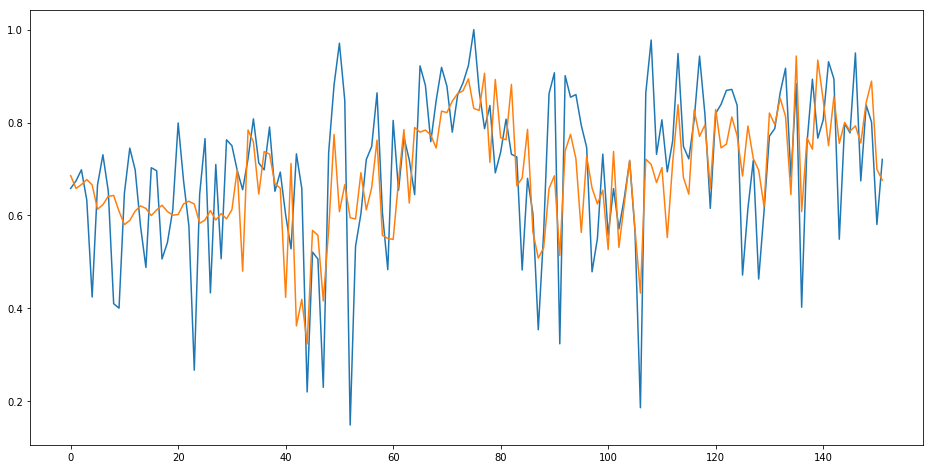

In [24]:
def sarimax_function(gen, exog, search=False, param_default = (0, 1, 1), param_seasonal_default=(0,0,0,12)):
    
    if search:
        p = d = q = range(0, 2)
        # Generate all different combinations of p, q and q triplets
        pdq = list(itertools.product(p, d, q))

        # Generate all different combinations of seasonal p, q and q triplets
        seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

        warnings.filterwarnings("ignore") # specify to ignore warning messages

        best_model = None
        best_AIC = np.inf 

        for param in pdq:
            if any(param) !=0:
                for param_seasonal in seasonal_pdq:
                    try:
                        mod = SARIMAX(gen, exog=exog, order=param, seasonal_order=param_seasonal, enforce_stationarity=False,
                                    enforce_invertibility=False)

                        results = mod.fit(disp=False)
                        print('ARIMA{}, x{} - AIC:{}'.format(param, param_seasonal, results.aic))
                        if results.aic < best_AIC:
                            best_AIC = results.aic
                            best_model = results.predict()
                            print('BEST: ', best_AIC, param, param_seasonal)
                    except:
                        continue
    
    else:
        mod = SARIMAX(gen, exog=exog, order=param_default, seasonal_order=param_seasonal_default, enforce_stationarity=False,
                        enforce_invertibility=False)
        results = mod.fit(disp=False)
        best_model = results.predict()

    return best_model

y_sarimax = sarimax_function(gen, exog, search=True)
plt.figure(figsize=(16,8))
plt.plot(gen[1:])
plt.plot(y_sarimax[1:])

In [25]:
dict_gen_ysarimax = {'generation':gen, 'y_sarimax':y_sarimax, 'data_inicial':data_inicial}
 
pickle.dump(dict_gen_ysarimax, open('dict_gen_ysarimax.pckl', 'wb'))

# Algoritmo AG

In [50]:
import warnings
warnings.filterwarnings("ignore")

ag_main = Ag_main(gen, y_sarimax, num_epochs = 7, size_pop = 100, prob_mut=0.5, tr_ts_percents=[80,20]).search_best_model()
best = ag_main._best_of_all
#pickle.dump(best, open('best_model_all.pckl', 'wb'))

start_set_fit: 0


  0%|          | 0/7 [00:00<?, ?it/s]

generation: 0
start_set_fit: 0


 14%|█▍        | 1/7 [02:59<17:57, 179.65s/it]

generation: 1
start_set_fit: 7


 29%|██▊       | 2/7 [05:42<14:33, 174.76s/it]

generation: 2
start_set_fit: 14


 43%|████▎     | 3/7 [08:24<11:23, 170.90s/it]

generation: 3
start_set_fit: 21


 57%|█████▋    | 4/7 [10:48<08:08, 162.85s/it]

generation: 4
start_set_fit: 28


 71%|███████▏  | 5/7 [13:14<05:15, 157.59s/it]

generation: 5
start_set_fit: 35


 86%|████████▌ | 6/7 [15:23<02:29, 149.17s/it]

generation: 6
start_set_fit: 42


100%|██████████| 7/7 [17:29<00:00, 142.02s/it]


# Análise Resultados

In [5]:
dict_series = pickle.load(open('dict_gen_ysarimax.pckl', 'rb'))
MaxAbsScaler_gen = pickle.load(open('MaxAbsScaler_gen.pckl', 'rb'))

gen = dict_series['generation']
y_sarimax = dict_series['y_sarimax']

In [16]:
len(gen)

153

[6, 7, 2, 15, MLPRegressor(activation='identity', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(78, 51, 8), learning_rate='invscaling',
             learning_rate_init=0.001, max_iter=500, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False), MLPRegressor(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(65, 30, 3), learning_rate='constant',
             learning_rate_init=0.001, max_iter=500, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='lbfgs', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_s

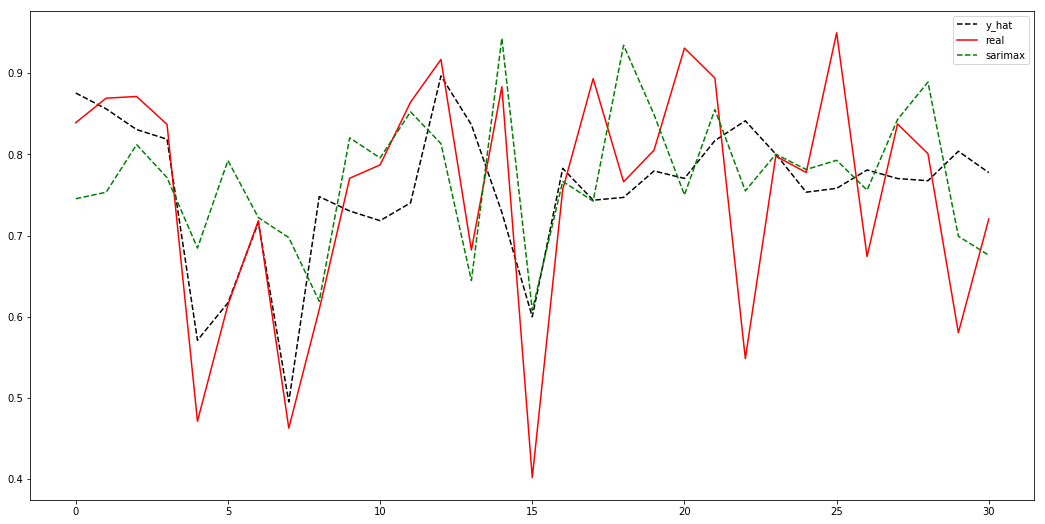

In [6]:
best = pickle.load(open('best_model_all.pckl', 'rb'))

erro = gen - y_sarimax

threshold = int(len(y_sarimax)*0.8)

data_train = gen[0:threshold]
data_test = gen[threshold:]

erro_train_entrada, erro_train_saida, erro_test_entrada, erro_test_saida = train_test_split(erro, best[0], [80, 20])
erro_estimado = np.concatenate((best[4].predict(erro_train_entrada), best[4].predict(erro_test_entrada)))

X_ass_1_train_in, _, X_ass_1_test_in, _ = train_test_split(y_sarimax, best[1], [80, 20])
X_ass_2_train_in, _, X_ass_2_test_in, _ = train_test_split_prev(erro_estimado, best[2], best[3], [80, 20])

X_in_train = np.concatenate((X_ass_1_train_in, X_ass_2_train_in), axis=1)
X_in_test = np.concatenate((X_ass_1_test_in, X_ass_2_test_in), axis=1) 

y_estimado = np.concatenate([best[5].predict(X_in_train), best[5].predict(X_in_test)])

print(best)
print (mae(best[5].predict(X_in_test), data_test) ==  best[6])

print('Resultado Dados Teste!')
print('ARIMA')
print('MAE: ', mae(y_sarimax[-len(data_test):], data_test))
print('MSE: ', mse(y_sarimax[-len(data_test):], data_test))
print('MAPE: ', MAPE(y_sarimax[-len(data_test):], data_test))
print('HIBRIDO')
print('MAE: ', mae(best[5].predict(X_in_test), data_test))
print('MSE: ', mse(best[5].predict(X_in_test), data_test))
print('MAPE: ', MAPE(best[5].predict(X_in_test), data_test))

print ('GANHO MAE:')
print (1-mae(best[5].predict(X_in_test), data_test)/mae(y_sarimax[-len(data_test):], data_test))

plt.figure(figsize=(18,9))
plt.plot(y_estimado[-len(data_test):], 'k--', label='y_hat')
plt.plot(gen[-len(data_test):], 'r', label='real')
plt.plot(y_sarimax[-len(data_test):], 'g--', label='sarimax')
plt.legend()

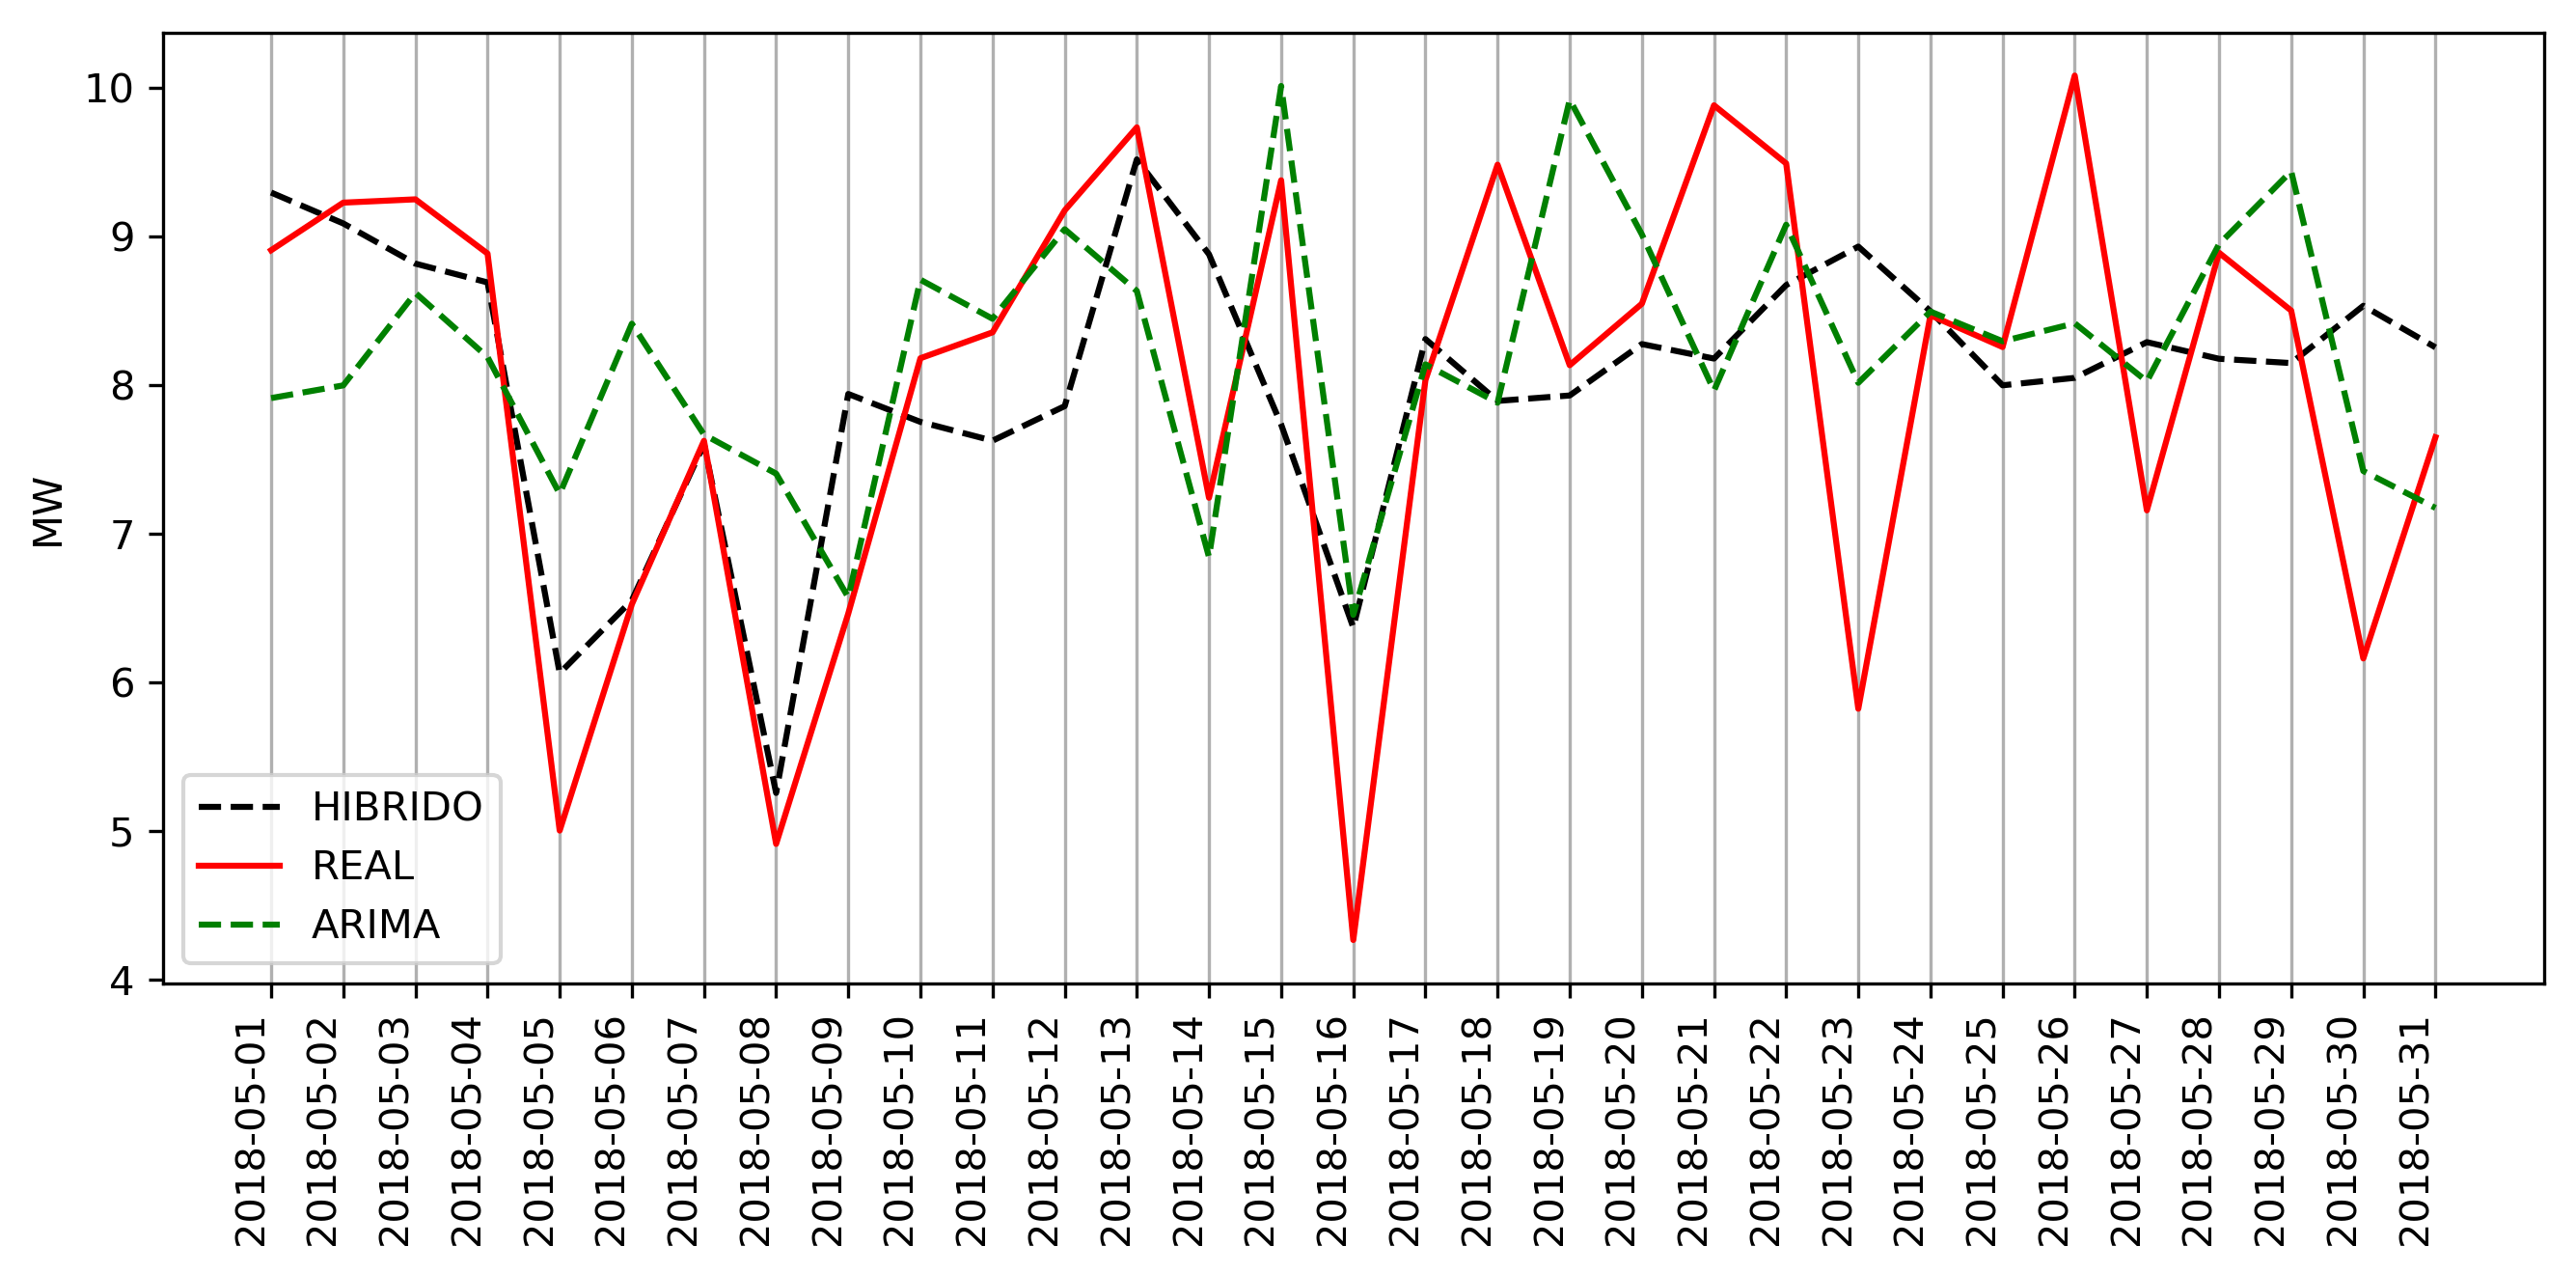

In [14]:
fig, ax = plt.subplots(1,1, figsize=(9,4.5), dpi=300)

ticks = [np.datetime64(np.datetime_as_string(x, timezone='local')[:10]).astype('str') for x in df_exo.Data[-len(data_test):].values]

ax.plot(ticks, MaxAbsScaler_gen.inverse_transform(y_estimado[-len(data_test):].reshape(-1, 1)), 'k--', label='HIBRIDO')
ax.plot(ticks, MaxAbsScaler_gen.inverse_transform(gen[-len(data_test):].reshape(-1, 1)), 'r', label='REAL')
ax.plot(ticks, MaxAbsScaler_gen.inverse_transform(y_sarimax[-len(data_test):].reshape(-1, 1)), 'g--', label='ARIMA')
plt.xticks(ticks, rotation=90, ha='right')
ax.grid(axis='x')
    
ax.legend()
ax.set_ylabel('MW')
plt.tight_layout()
plt.savefig('time_series_assu_5.png', dpi=300)

In [17]:
len(data_test)

31

In [18]:
len(gen) - len(data_test)

122